# Qualitative vs Quantitative Sleep
This notebook looks exclusively at sleep quality as reported by the participants versus what Fitbit was able to measure.

The notebook is organized as follows:
1. [Data Import and Pre-Processing](#import)
2. [Processing](#process)
3. [Visualization and Analysis](#visualize)

# Data Import

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os

## Fitbit Data
Luckily, the fitbit data as already been processed and stored in ```/data/processed/```.

In [2]:
sleepSummary = pd.read_csv('/Users/hagenfritz/Projects/utx000/data/processed/ut3000-fitbit-sleepstagesummary.csv',
                          index_col=0,parse_dates=True,infer_datetime_format=True)

sleepSummary['TotalHoursAsleep'] = sleepSummary['TotalMinutesAsleep']/60
sleepSummary['TotalHoursREM'] = sleepSummary['TotalMinutesREM']/60
sleepSummary['TotalHoursNREM'] = sleepSummary['TotalMinutesNREM']/60

sleepSummary.head()

,Id,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,TotalTimeAwake,TotalMinutesLight,TotalMinutesDeep,TotalMinutesREM,study,record,beiwe,beacon,TotalMinutesNREM,REM:NREM,TotalHoursAsleep,TotalHoursREM,TotalHoursNREM
SleepDay,,,,,,,,,,,,,,,,,
2018-10-30,1025,1,293,346,53,203,45,45,ut1000,1025,2qki3fim,NaN,248,0.181452,4.883333,0.750000,4.133333
2018-10-31,1025,1,523,575,52,308,113,102,ut1000,1025,2qki3fim,NaN,421,0.242280,8.716667,1.700000,7.016667
2018-11-01,1025,1,288,326,38,169,47,72,ut1000,1025,2qki3fim,NaN,216,0.333333,4.800000,1.200000,3.600000
2018-11-02,1025,1,529,592,63,316,99,114,ut1000,1025,2qki3fim,NaN,415,0.274699,8.816667,1.900000,6.916667
2018-11-03,1025,1,415,480,65,237,96,82,ut1000,1025,2qki3fim,NaN,333,0.246246,6.916667,1.366667,5.550000


## Beiwe Data
The beiwe data have been processed to different extents depending on the study. Peter Wu has summarized the sleep data nicely for the UT2000 study.

In [3]:
def combine_beiwe_studies(fileString='sleep'):
    '''
    
    '''
    df = pd.DataFrame()
    for i in range(2):
        temp = pd.read_csv(f'/Users/hagenfritz/Projects/utx000/data/raw/ut{i+1}000/beiwe/{fileString}.csv')
        temp['study'] = f'ut{i+1}000'

        crossover = pd.read_csv(f'/Users/hagenfritz/Projects/utx000/data/raw/ut{i+1}000/admin/id_crossover.csv')
        temp = pd.merge(left=temp,right=crossover,left_on='pid',right_on='beiwe',how='left')
        df = pd.concat([df,temp])
        
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date',inplace=True)
    df.drop('Unnamed: 0',axis=1,inplace=True)
    if fileString == 'sleep':
        df['hours'] = df['answer']
        df.drop('answer',axis=1,inplace=True)
    elif fileString == 'refreshed':
        df['refreshed'] = df['answer']
        df.drop('answer',axis=1,inplace=True)
    elif fileString == 'restful':
        df['restful'] = df['answer']
        df.drop('answer',axis=1,inplace=True)
    else:
        pass
        
    return df

Getting Beiwe dataframes. Unfortunately they are not the same length so we cannot combined them into a single dataframe. 

In [4]:
sleep = combine_beiwe_studies()
refreshed = combine_beiwe_studies('refreshed')
restful = combine_beiwe_studies('restful')

# Processing 
Processing involves combining the dataframes.

In [5]:
def merge_fitbit_with_beiwe(fb_df, bw_df, bw_col):
    '''
    
    '''
    df = pd.DataFrame()
    for bid in fb_df['beiwe'].unique():
        fb_by_id = fb_df[fb_df['beiwe'] == bid]
        bw_by_id = bw_df[bw_df['beiwe'] == bid]
        temp = pd.merge(left=fb_by_id,left_index=True,right=bw_by_id[bw_col],right_index=True,how='inner')
        df = pd.concat([df,temp])
        
    return df

In [6]:
sleepTime = merge_fitbit_with_beiwe(sleepSummary, sleep, 'hours')
sleepTime = sleepTime[sleepTime['hours'] >= 3]
sleepTime = sleepTime[sleepTime['TotalHoursAsleep'] >= 3]
sleepTime.to_csv('../data/processed/ut3000-beiwe-fitbit-tst-sleep.csv')
sleepTime.head()

,Id,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,TotalTimeAwake,TotalMinutesLight,TotalMinutesDeep,TotalMinutesREM,study,record,beiwe,beacon,TotalMinutesNREM,REM:NREM,TotalHoursAsleep,TotalHoursREM,TotalHoursNREM,hours
2018-10-30,1025,1,293,346,53,203,45,45,ut1000,1025,2qki3fim,NaN,248,0.181452,4.883333,0.750000,4.133333,4.0
2018-10-31,1025,1,523,575,52,308,113,102,ut1000,1025,2qki3fim,NaN,421,0.242280,8.716667,1.700000,7.016667,8.0
2018-11-02,1025,1,529,592,63,316,99,114,ut1000,1025,2qki3fim,NaN,415,0.274699,8.816667,1.900000,6.916667,8.0
2018-11-03,1025,1,415,480,65,237,96,82,ut1000,1025,2qki3fim,NaN,333,0.246246,6.916667,1.366667,5.550000,5.0
2018-10-27,1254,2,498,567,62,276,91,32,ut1000,1254,4vbys6c4,NaN,367,0.087193,8.300000,0.533333,6.116667,6.0


In [7]:
sleepRefreshed = merge_fitbit_with_beiwe(sleepSummary, refreshed, 'refreshed')
sleepRefreshed.to_csv('../data/processed/ut3000-beiwe-fitbit-refresh-sleep.csv')
sleepRefreshed.head()

,Id,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,TotalTimeAwake,TotalMinutesLight,TotalMinutesDeep,TotalMinutesREM,study,record,beiwe,beacon,TotalMinutesNREM,REM:NREM,TotalHoursAsleep,TotalHoursREM,TotalHoursNREM,refreshed
2018-10-30,1025,1,293,346,53,203,45,45,ut1000,1025,2qki3fim,NaN,248,0.181452,4.883333,0.750000,4.133333,0
2018-10-31,1025,1,523,575,52,308,113,102,ut1000,1025,2qki3fim,NaN,421,0.242280,8.716667,1.700000,7.016667,0
2018-11-02,1025,1,529,592,63,316,99,114,ut1000,1025,2qki3fim,NaN,415,0.274699,8.816667,1.900000,6.916667,0
2018-11-03,1025,1,415,480,65,237,96,82,ut1000,1025,2qki3fim,NaN,333,0.246246,6.916667,1.366667,5.550000,0
2018-10-27,1254,2,498,567,62,276,91,32,ut1000,1254,4vbys6c4,NaN,367,0.087193,8.300000,0.533333,6.116667,0


In [8]:
sleepRestful = merge_fitbit_with_beiwe(sleepSummary, restful, 'restful')
sleepRestful.to_csv('../data/processed/ut3000-beiwe-fitbit-restful-sleep.csv')
for pid in sleepRestful['beiwe'].unique():
    df = sleepRestful[sleepRestful['beiwe'] == pid]
    if len(df) < 3:
        sleepRestful = sleepRestful[sleepRestful['beiwe'] != pid]
sleepRestful.head()

,Id,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,TotalTimeAwake,TotalMinutesLight,TotalMinutesDeep,TotalMinutesREM,study,record,beiwe,beacon,TotalMinutesNREM,REM:NREM,TotalHoursAsleep,TotalHoursREM,TotalHoursNREM,restful
2018-10-30,1025,1,293,346,53,203,45,45,ut1000,1025,2qki3fim,NaN,248,0.181452,4.883333,0.750000,4.133333,0
2018-10-31,1025,1,523,575,52,308,113,102,ut1000,1025,2qki3fim,NaN,421,0.242280,8.716667,1.700000,7.016667,0
2018-11-02,1025,1,529,592,63,316,99,114,ut1000,1025,2qki3fim,NaN,415,0.274699,8.816667,1.900000,6.916667,0
2018-11-03,1025,1,415,480,65,237,96,82,ut1000,1025,2qki3fim,NaN,333,0.246246,6.916667,1.366667,5.550000,0
2018-10-27,1254,2,498,567,62,276,91,32,ut1000,1254,4vbys6c4,NaN,367,0.087193,8.300000,0.533333,6.116667,1


<a id='visualize'></a>
# Visualization and Analysis

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from scipy import stats
import statsmodels.api as sm

## Study Overlap
Just a quick visualization to see where and where not the studies overlap.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


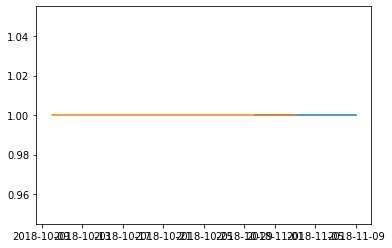

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


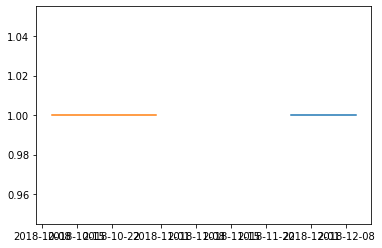

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


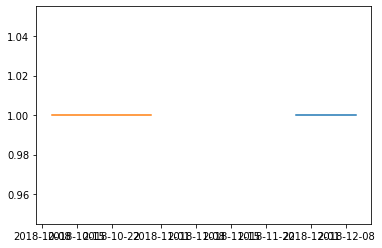

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


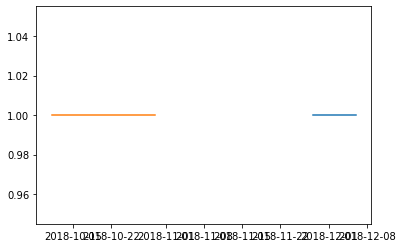

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


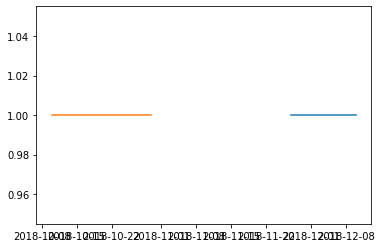

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


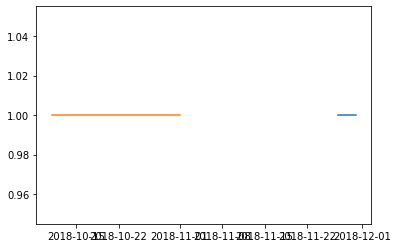

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


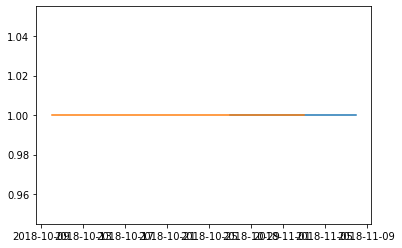

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


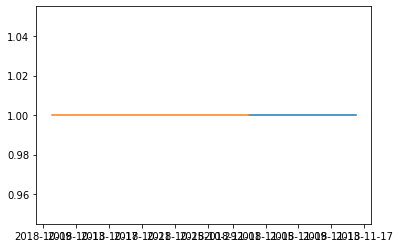

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


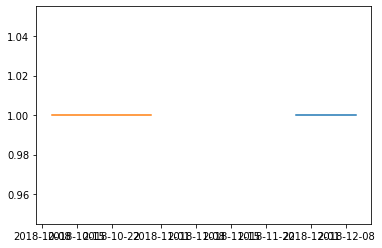

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


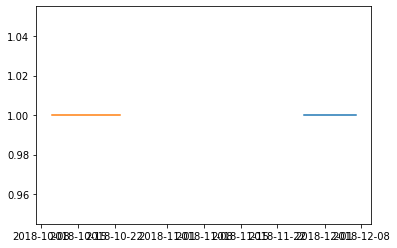

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


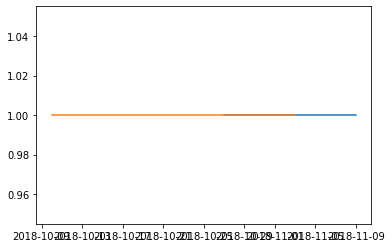

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


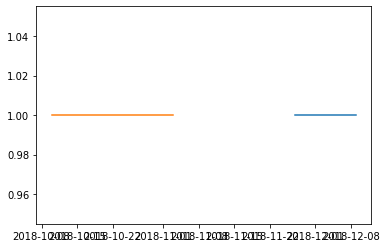

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


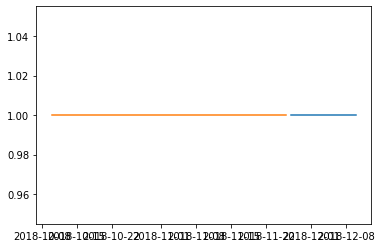

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


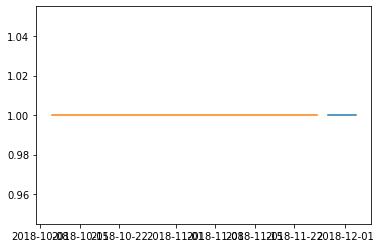

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


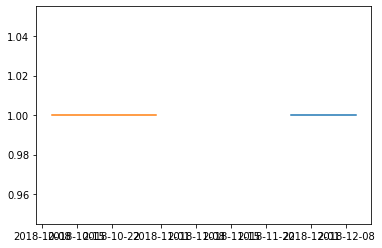

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


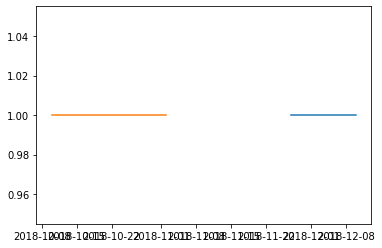

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


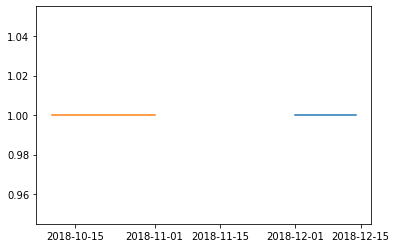

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


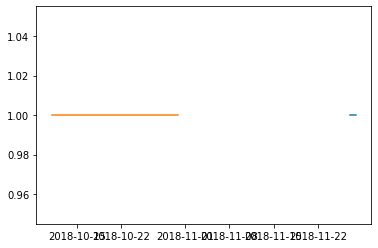

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


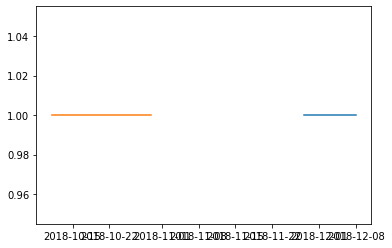

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


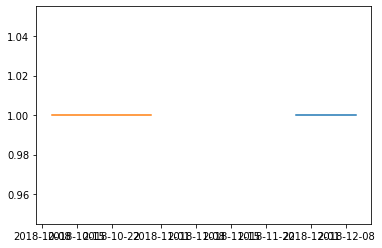

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


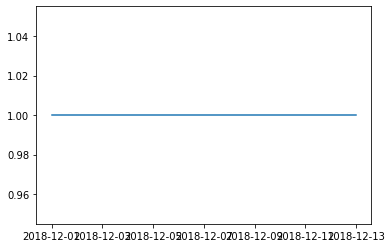

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


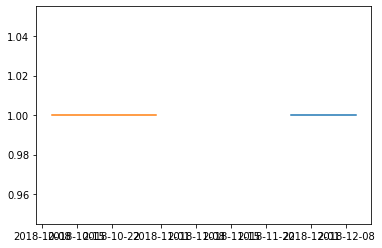

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


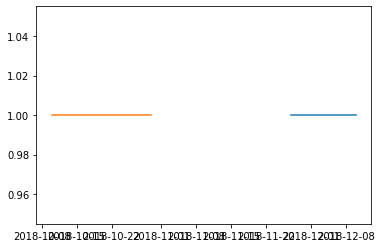

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


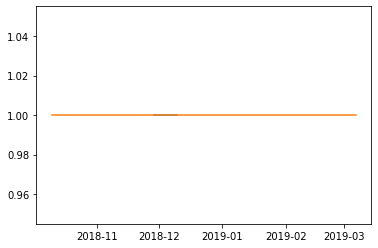

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


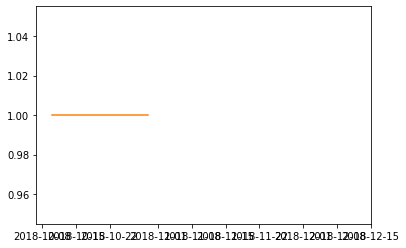

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


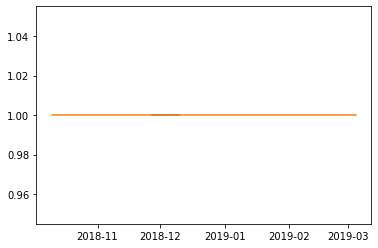

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


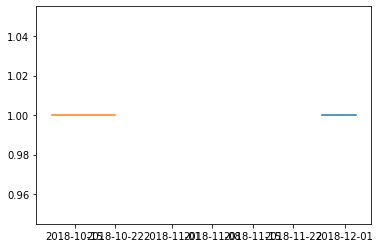

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


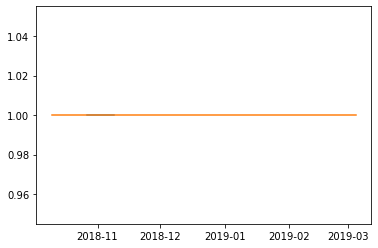

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


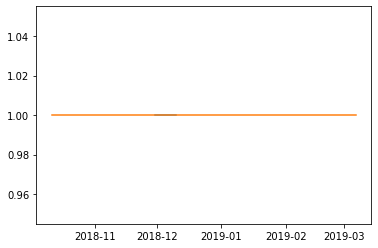

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


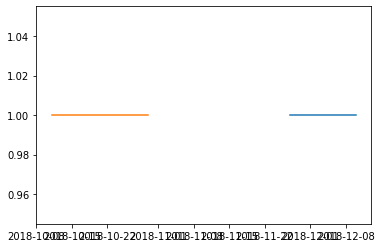

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


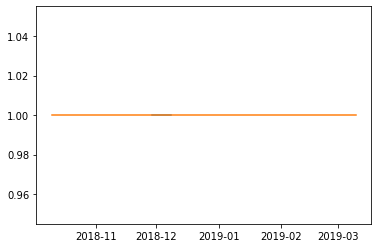

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


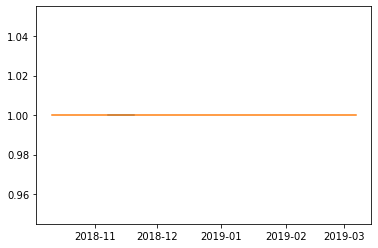

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


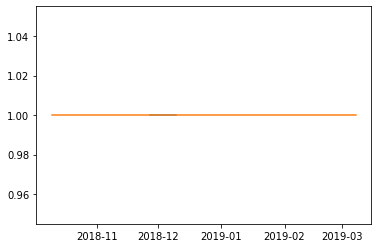

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


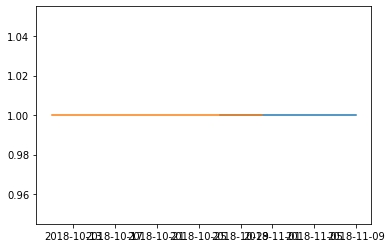

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


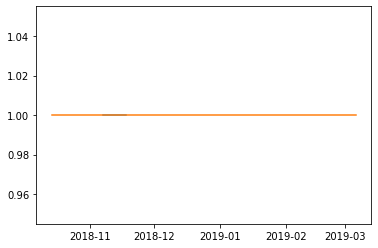

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


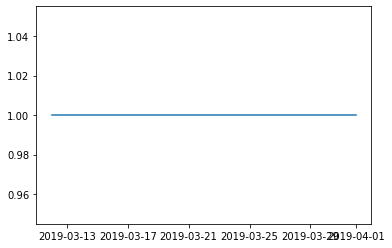

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


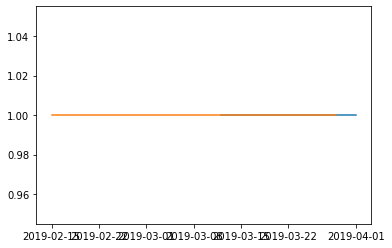

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


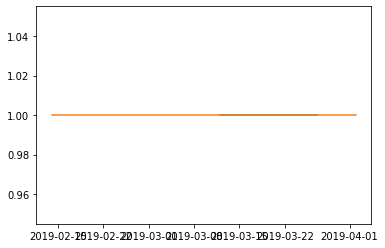

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


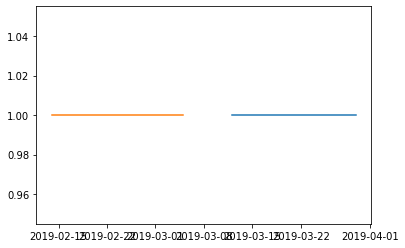

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


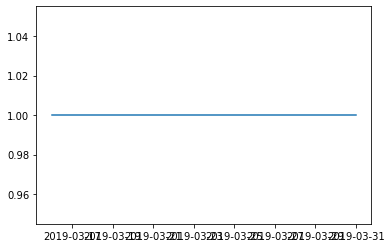

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


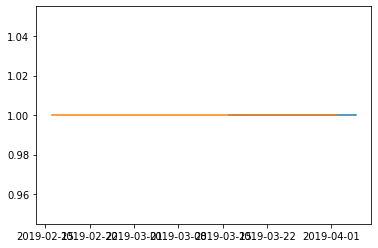

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


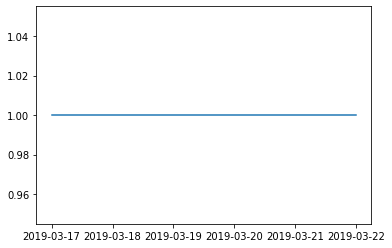

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


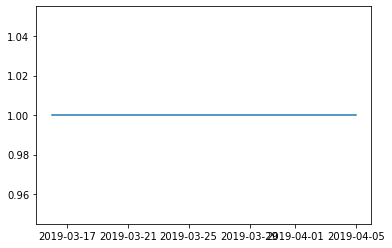

In [10]:
for rid in sleepSummary['record'].unique():
    fb = sleepSummary[sleepSummary['record'] == rid]
    bw = sleep[sleep['record'] == rid]
    fb['measurement'] = 1
    bw['measurement'] = 1
    fig, ax = plt.subplots()
    ax.plot(fb.index,fb['measurement'])
    ax.plot(bw.index,bw['measurement'])
    plt.show()
    plt.close()

## Sleep Time
Here we use a scatter plot to see how well participants are able to estimate their total sleep time. 

Averaging values for each participant so we don't have a mixed-effect model

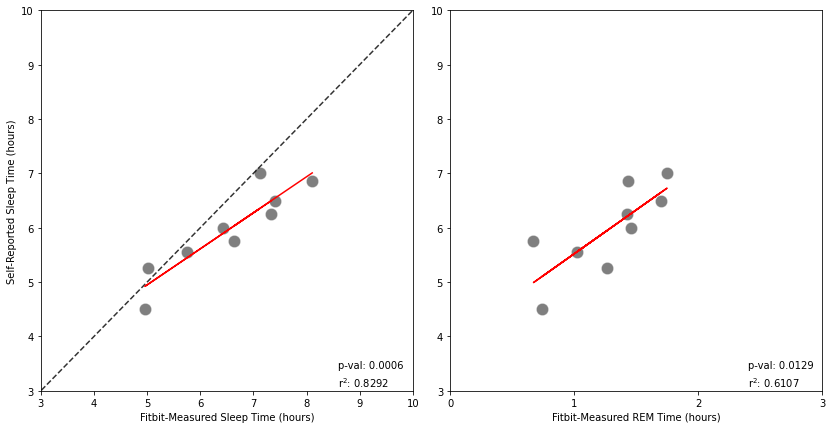

In [11]:
fig, axes = plt.subplots(1,2,figsize=(14,7))
ax = axes[0]
# ------------------------------------------
# No mixed effect
dfToUse = sleepTime.groupby('record').mean()
# Mixed effect
#dfToUse = sleepTime
# ------------------------------------------
sns.scatterplot(x='TotalHoursAsleep',y='hours',color='black',alpha=0.5,s=150,data=dfToUse,ax=ax)
# y=x
ax.plot([0,11],[0,11],linestyle='dashed',alpha=0.8,color='black')
# x-axis
ax.set_xlim([3,10])
ax.set_xticks(np.arange(3,11))
ax.set_xlabel('Fitbit-Measured Sleep Time (hours)')
# y-axis
ax.set_ylim([3,10])
ax.set_yticks(np.arange(3,11))
ax.set_ylabel('Self-Reported Sleep Time (hours)')

X = dfToUse['TotalHoursAsleep'].values
Y = dfToUse['hours'].values
t = np.arange(len(X))
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) # make the predictions by the model

## Line of Best Fit
ax.plot(X[:,1],predictions,color='red')

## Formatting Remainder of Axis
xlim = [3,10]
ylim = [3,10]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
### Print out the statistics
loc_x = max(xlim)-0.2*(max(xlim)-min(xlim))
loc_y = min(ylim)+0.01*(max(ylim)-min(ylim))
#ax.text(loc_x,loc_y+0.1*(max(ylim)-min(ylim)),'Intercept: ' + str(round(model.params[0],2)))
ax.text(loc_x,loc_y+0.05*(max(ylim)-min(ylim)),'p-val: ' + str(round(model.f_pvalue,4)))
ax.text(loc_x,loc_y,'r$^2$: ' + str(round(model.rsquared,4)))

ax = axes[1]
dfToUse['TotalHoursREM'] = dfToUse['TotalMinutesREM']/60
sns.scatterplot(x='TotalHoursREM',y='hours',color='black',alpha=0.5,s=150,data=dfToUse,ax=ax)
# x-axis
ax.set_xlim([0,3])
ax.set_xticks(np.arange(0,4))
ax.set_xlabel('Fitbit-Measured REM Time (hours)')
# y-axis
ax.set_ylim([3,10])
ax.set_yticks(np.arange(3,11))
ax.set_ylabel('')

X = dfToUse['TotalHoursREM'].values
Y = dfToUse['hours'].values
t = np.arange(len(X))
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) # make the predictions by the model

## Line of Best Fit
ax.plot(X[:,1],predictions,color='red')

## Formatting Remainder of Axis
xlim = [0,3]
ylim = [3,10]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
### Print out the statistics
loc_x = max(xlim)-0.2*(max(xlim)-min(xlim))
loc_y = min(ylim)+0.01*(max(ylim)-min(ylim))
#ax.text(loc_x,loc_y+0.1*(max(ylim)-min(ylim)),'Intercept: ' + str(round(model.params[0],2)))
ax.text(loc_x,loc_y+0.05*(max(ylim)-min(ylim)),'p-val: ' + str(round(model.f_pvalue,4)))
ax.text(loc_x,loc_y,'r$^2$: ' + str(round(model.rsquared,4)))

#
plt.subplots_adjust(wspace=0.1)
plt.savefig('/Users/hagenfritz/Projects/utx000/reports/figures/framework_paper/ut3000-fitbit-beiwe-tst-tst-scatter.png')

plt.show()
plt.close()

## Restful Sleep
There should be some relationship between REM sleep and how restful the participants felt their sleep was.

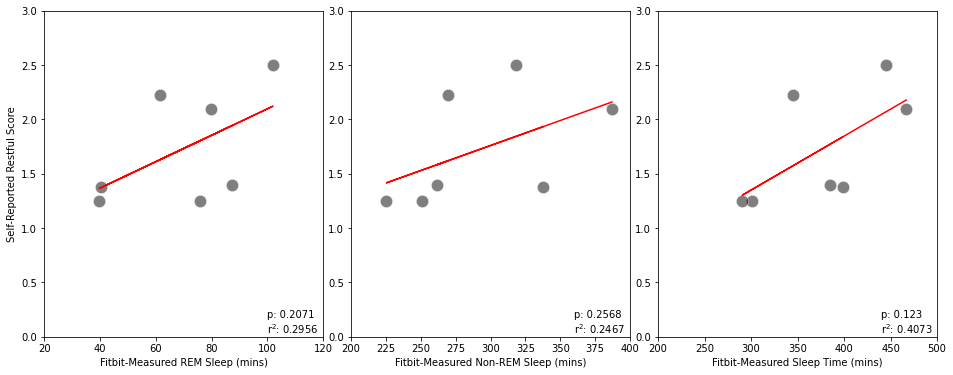

In [12]:
fig, axes = plt.subplots(1,3,figsize=(16,6))
ax = axes[0]
# ------------------------------------------
# No mixed effect
dfToUse = sleepRestful.groupby('record').mean()
# Mixed effect
#dfToUse = sleepRestful
# ------------------------------------------
dfToUse = dfToUse[dfToUse['restful'] > 0]
sns.scatterplot(x='TotalMinutesREM',y='restful',color='black',alpha=0.5,s=150,data=dfToUse,ax=ax)
# x-axis
xlim = [20,120]
ax.set_xlim(xlim)
ax.set_xlabel('Fitbit-Measured REM Sleep (mins)')
# y-axis
ylim = [0,3]
ax.set_ylim(ylim)
ax.set_ylabel('Self-Reported Restful Score')

X = dfToUse['TotalMinutesREM'].values
Y = dfToUse['restful'].values
t = np.arange(len(X))
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) # make the predictions by the model

## Line of Best Fit
ax.plot(X[:,1],predictions,color='red')

### Print out the statistics
loc_x = max(xlim)-0.2*(max(xlim)-min(xlim))
loc_y = min(ylim)+0.01*(max(ylim)-min(ylim))
#ax.text(loc_x,loc_y+0.1*(max(ylim)-min(ylim)),'Intercept: ' + str(round(model.params[0],2)))
#ax.text(loc_x,loc_y+0.05*(max(ylim)-min(ylim)),'Slope: ' + str(round(model.params[1],2)))
ax.text(loc_x,loc_y+0.05*(max(ylim)-min(ylim)),'p: ' + str(round(model.f_pvalue,4)))
ax.text(loc_x,loc_y,'r$^2$: ' + str(round(model.rsquared,4)))

ax = axes[1]
sns.scatterplot(x='TotalMinutesNREM',y='restful',color='black',alpha=0.5,s=150,data=dfToUse,ax=ax)
# x-axis
xlim = [200,400]
ax.set_xlim(xlim)
ax.set_xlabel('Fitbit-Measured Non-REM Sleep (mins)')
# y-axis
ax.set_ylim(ylim)
ax.set_ylabel('')

X = dfToUse['TotalMinutesNREM'].values
Y = dfToUse['restful'].values
t = np.arange(len(X))
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) # make the predictions by the model

## Line of Best Fit
ax.plot(X[:,1],predictions,color='red')

### Print out the statistics
loc_x = max(xlim)-0.2*(max(xlim)-min(xlim))
loc_y = min(ylim)+0.01*(max(ylim)-min(ylim))
#ax.text(loc_x,loc_y+0.1*(max(ylim)-min(ylim)),'Intercept: ' + str(round(model.params[0],2)))
#ax.text(loc_x,loc_y+0.05*(max(ylim)-min(ylim)),'Slope: ' + str(round(model.params[1],2)))
ax.text(loc_x,loc_y+0.05*(max(ylim)-min(ylim)),'p: ' + str(round(model.f_pvalue,4)))
ax.text(loc_x,loc_y,'r$^2$: ' + str(round(model.rsquared,4)))

ax = axes[2]
sns.scatterplot(x='TotalMinutesAsleep',y='restful',color='black',alpha=0.5,s=150,data=dfToUse,ax=ax)
# x-axis
xlim = [200,500]
ax.set_xlim(xlim)
ax.set_xlabel('Fitbit-Measured Sleep Time (mins)')
# y-axis
ax.set_ylim(ylim)
ax.set_ylabel('')

X = dfToUse['TotalMinutesAsleep'].values
Y = dfToUse['restful'].values
t = np.arange(len(X))
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) # make the predictions by the model

## Line of Best Fit
ax.plot(X[:,1],predictions,color='red')

### Print out the statistics
loc_x = max(xlim)-0.2*(max(xlim)-min(xlim))
loc_y = min(ylim)+0.01*(max(ylim)-min(ylim))
#ax.text(loc_x,loc_y+0.1*(max(ylim)-min(ylim)),'Intercept: ' + str(round(model.params[0],2)))
#ax.text(loc_x,loc_y+0.05*(max(ylim)-min(ylim)),'Slope: ' + str(round(model.params[1],2)))
ax.text(loc_x,loc_y+0.05*(max(ylim)-min(ylim)),'p: ' + str(round(model.f_pvalue,4)))
ax.text(loc_x,loc_y,'r$^2$: ' + str(round(model.rsquared,4)))

#
plt.subplots_adjust(wspace=0.1)
plt.savefig('/Users/hagenfritz/Projects/utx000/reports/figures/framework_paper/ut3000-fitbit-beiwe-REMandNREM-restful-scatter.png')

plt.show()
plt.close()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:434: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


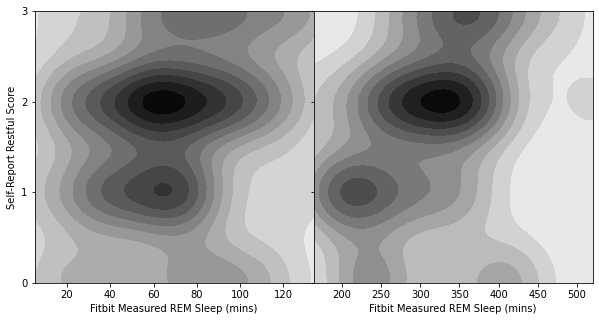

In [13]:
fig, axes = plt.subplots(1,2,figsize=(10,5),sharey=True)
# ------------------------------------------
# No mixed effect
dfToUse = sleepRestful.groupby('record').mean()
# Mixed effect
#dfToUse = sleepRestful
# ------------------------------------------
#REM
ax = axes[0]
sns.kdeplot(sleepRestful['TotalMinutesREM'],sleepRestful['restful'],color='black',edgecolor='black',cut=0,shade=True,ax=ax)
# x-axis
ax.set_xlabel('Fitbit Measured REM Sleep (mins)')
# y-axis
ax.set_yticks(np.arange(4))
ax.set_ylabel('Self-Report Restful Score')
#NREM
ax = axes[1]
sns.kdeplot(sleepRestful['TotalMinutesNREM'],sleepRestful['restful'],color='black',edgecolor='black',cut=0,shade=True,ax=ax)
# x-axis
ax.set_xlabel('Fitbit Measured REM Sleep (mins)')
# y-axis
ax.set_yticks(np.arange(4))
ax.set_ylabel('')
# 
plt.subplots_adjust(wspace=0)
plt.savefig('/Users/hagenfritz/Projects/utx000/reports/figures/framework_paper/ut3000-fitbit-beiwe-REMandNREM-restful-density.png')
plt.show()
plt.close()

# Testing Mixed Effect Models
Looking into usage of the statsmodel package below more...

In [14]:
import statsmodels.formula.api as smf

So we have random effects introduced because we have a longitudinal study where participants are queried multiple time for their sleep time via survey. So there will be random effects associated with each participant i.e.
- some participants might determine the hours they slept on the difference in time they got out of bed and time they got in bed
- others might use the same difference but then subtract the time they think it took them to fall asleep (such as 15/20 minutes) from that time

These potential differences in addition to others introduce random effects in the self-reported sleep time. 

As of now, we will leave Fitbit-measured sleep time alone since the method Fitbit uses to measure sleep should be more homogeneous from participant to participant with only slight nuances.

In [15]:
sleepTime = sleepTime[sleepTime['beiwe'] != 'wq83wttc']
sleepTime = sleepTime[sleepTime['beiwe'] != '7ao7sz2v']

sleepTime.head()

,Id,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,TotalTimeAwake,TotalMinutesLight,TotalMinutesDeep,TotalMinutesREM,study,record,beiwe,beacon,TotalMinutesNREM,REM:NREM,TotalHoursAsleep,TotalHoursREM,TotalHoursNREM,hours
2018-10-30,1025,1,293,346,53,203,45,45,ut1000,1025,2qki3fim,NaN,248,0.181452,4.883333,0.750000,4.133333,4.0
2018-10-31,1025,1,523,575,52,308,113,102,ut1000,1025,2qki3fim,NaN,421,0.242280,8.716667,1.700000,7.016667,8.0
2018-11-02,1025,1,529,592,63,316,99,114,ut1000,1025,2qki3fim,NaN,415,0.274699,8.816667,1.900000,6.916667,8.0
2018-11-03,1025,1,415,480,65,237,96,82,ut1000,1025,2qki3fim,NaN,333,0.246246,6.916667,1.366667,5.550000,5.0
2018-10-27,1254,2,498,567,62,276,91,32,ut1000,1254,4vbys6c4,NaN,367,0.087193,8.300000,0.533333,6.116667,6.0


2qki3fim: 4
4vbys6c4: 8
yiylwp46: 5
oo7mbow3: 4
ej8gbvzs: 4
fwx7pdjp: 9
36dsqll3: 7


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2114: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2114: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/

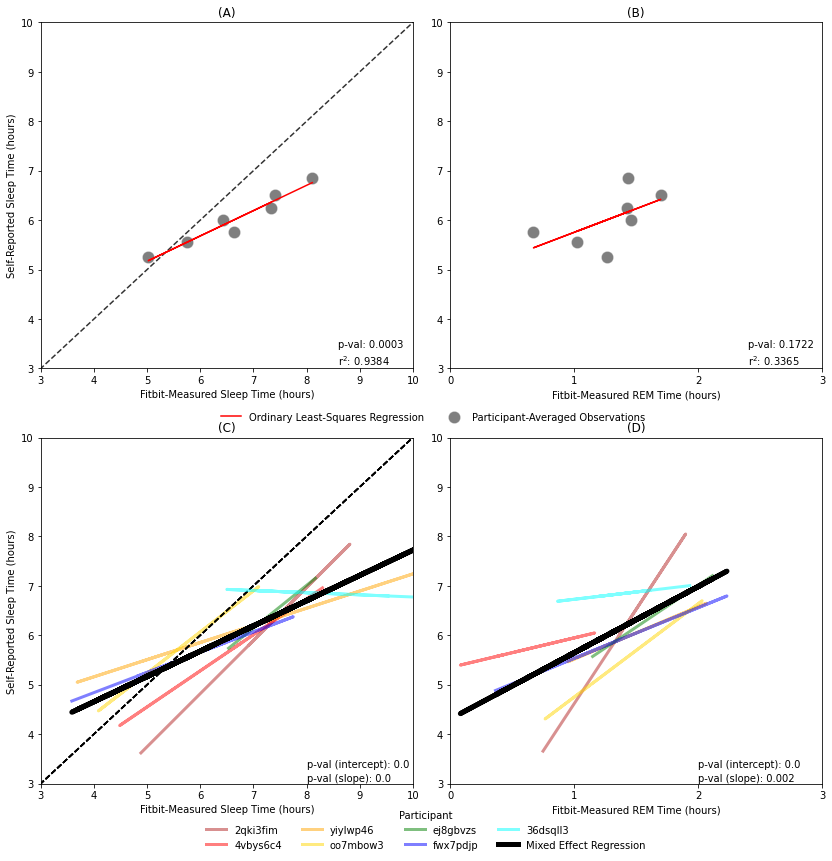

In [16]:
fig, axes = plt.subplots(2,2,figsize=(14,14))
colors = ['firebrick','red','orange','gold','green','blue','cyan','violet','black']
i = 0
for pid in sleepTime['beiwe'].unique():
    sleepByID = sleepTime[sleepTime['beiwe'] == pid]
    print(f'{pid}: {len(sleepByID)}')
    if len(sleepByID) > 1:
        #sns.scatterplot(x='TotalHoursAsleep',y='hours',alpha=0.5,s=150,data=sleepByID,color=colors[i],ax=ax,label=pid)
        # y=x
        ax = axes[1,0]
        ax.plot([0,11],[0,11],linestyle='dashed',alpha=0.8,color='black')
        # x-axis
        ax.set_xlim([3,10])
        ax.set_xticks(np.arange(3,11))
        ax.set_xlabel('Fitbit-Measured Sleep Time (hours)')
        # y-axis
        ax.set_ylim([3,10])
        ax.set_yticks(np.arange(3,11))
        ax.set_ylabel('Self-Reported Sleep Time (hours)')
        
        X = sleepByID['TotalHoursAsleep'].values
        Y = sleepByID['hours'].values
        t = np.arange(len(X))
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        ## Line of Best Fit
        ax.plot(X[:,1],predictions,color=colors[i],alpha=0.5,linewidth=3)
        
        ax = axes[1,1]
        # x-axis
        ax.set_xlim([0,3])
        ax.set_xticks(np.arange(0,4))
        ax.set_xlabel('Fitbit-Measured REM Time (hours)')
        # y-axis
        ax.set_ylim([3,10])
        ax.set_yticks(np.arange(3,11))
        ax.set_ylabel('')
        
        X = sleepByID['TotalHoursREM'].values
        Y = sleepByID['hours'].values
        t = np.arange(len(X))
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        ## Line of Best Fit
        ax.plot(X[:,1],predictions,color=colors[i],alpha=0.5,linewidth=3,label=pid)

        i += 1
        

ax = axes[0,0]
# ------------------------------------------
# No mixed effect
dfToUse = sleepTime.groupby('record').mean()
# Mixed effect
#dfToUse = sleepTime
# ------------------------------------------
sns.scatterplot(x='TotalHoursAsleep',y='hours',color='black',alpha=0.5,s=150,data=dfToUse,ax=ax)
# y=x
ax.plot([0,11],[0,11],linestyle='dashed',alpha=0.8,color='black')
# x-axis
ax.set_xlim([3,10])
ax.set_xticks(np.arange(3,11))
ax.set_xlabel('Fitbit-Measured Sleep Time (hours)')
# y-axis
ax.set_ylim([3,10])
ax.set_yticks(np.arange(3,11))
ax.set_ylabel('Self-Reported Sleep Time (hours)')

X = dfToUse['TotalHoursAsleep'].values
Y = dfToUse['hours'].values
t = np.arange(len(X))
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) # make the predictions by the model

## Line of Best Fit
ax.plot(X[:,1],predictions,color='red')

## Formatting Remainder of Axis
xlim = [3,10]
ylim = [3,10]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
### Print out the statistics
loc_x = max(xlim)-0.2*(max(xlim)-min(xlim))
loc_y = min(ylim)+0.01*(max(ylim)-min(ylim))
#ax.text(loc_x,loc_y+0.1*(max(ylim)-min(ylim)),'Intercept: ' + str(round(model.params[0],2)))
ax.text(loc_x,loc_y+0.05*(max(ylim)-min(ylim)),'p-val: ' + str(round(model.f_pvalue,4)))
ax.text(loc_x,loc_y,'r$^2$: ' + str(round(model.rsquared,4)))
ax.set_title('(A)')

ax = axes[0,1]
dfToUse['TotalHoursREM'] = dfToUse['TotalMinutesREM']/60
sns.scatterplot(x='TotalHoursREM',y='hours',color='black',alpha=0.5,s=150,data=dfToUse,label='Participant-Averaged Observations',ax=ax)
# x-axis
ax.set_xlim([0,3])
ax.set_xticks(np.arange(0,4))
ax.set_xlabel('Fitbit-Measured REM Time (hours)')
# y-axis
ax.set_ylim([3,10])
ax.set_yticks(np.arange(3,11))
ax.set_ylabel('')

X = dfToUse['TotalHoursREM'].values
Y = dfToUse['hours'].values
t = np.arange(len(X))
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) # make the predictions by the model

## Line of Best Fit
ax.plot(X[:,1],predictions,color='red',label='Ordinary Least-Squares Regression')

## Formatting Remainder of Axis
xlim = [0,3]
ylim = [3,10]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
### Print out the statistics
loc_x = max(xlim)-0.2*(max(xlim)-min(xlim))
loc_y = min(ylim)+0.01*(max(ylim)-min(ylim))
#ax.text(loc_x,loc_y+0.1*(max(ylim)-min(ylim)),'Intercept: ' + str(round(model.params[0],2)))
ax.text(loc_x,loc_y+0.05*(max(ylim)-min(ylim)),'p-val: ' + str(round(model.f_pvalue,4)))
ax.text(loc_x,loc_y,'r$^2$: ' + str(round(model.rsquared,4)))
ax.set_title('(B)')
    
data = sleepTime
md = smf.mixedlm("hours ~ TotalHoursAsleep", data, groups=data["beiwe"], re_formula="~TotalHoursAsleep")
mdf = md.fit()
#print(mdf.summary())
axes[1,0].plot(sleepTime['TotalHoursAsleep'],mdf.predict(sleepTime['TotalHoursAsleep']),color='black',linewidth=5)
axes[1,0].text(8,3.5,f'p-val (intercept): {round(mdf.pvalues[0],3)}',va='top')
axes[1,0].text(8,3,f'p-val (slope): {round(mdf.pvalues[1],3)}',va='bottom')
axes[1,0].set_title('(C)')

md = smf.mixedlm("hours ~ TotalHoursREM", data, groups=data["beiwe"], re_formula="~TotalHoursREM")
mdf = md.fit()
#print(mdf.summary())
axes[1,1].plot(sleepTime['TotalHoursREM'],mdf.predict(sleepTime['TotalHoursREM']),color='black',linewidth=5,label='Mixed Effect Regression')
axes[1,1].text(2,3.5,f'p-val (intercept): {round(mdf.pvalues[0],3)}',va='top')
axes[1,1].text(2,3,f'p-val (slope): {round(mdf.pvalues[1],3)}',va='bottom')
axes[1,1].set_title('(D)')

axes[0,1].legend(bbox_to_anchor=(0.55,-0.1),ncol=4,frameon=False)
axes[1,1].legend(title='Participant',bbox_to_anchor=(0.55,-0.05),ncol=4,frameon=False)

plt.subplots_adjust(hspace=0.2,wspace=0.1)
plt.savefig('/Users/hagenfritz/Projects/utx000/reports/figures/framework_paper/ut3000-fitbit-beiwe-tst-tst-scatter.png')
plt.show()
plt.close()

### Mixed Effect Only

2qki3fim: 4
4vbys6c4: 8
yiylwp46: 5
oo7mbow3: 4
ej8gbvzs: 4
fwx7pdjp: 9
36dsqll3: 7


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2114: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2170: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


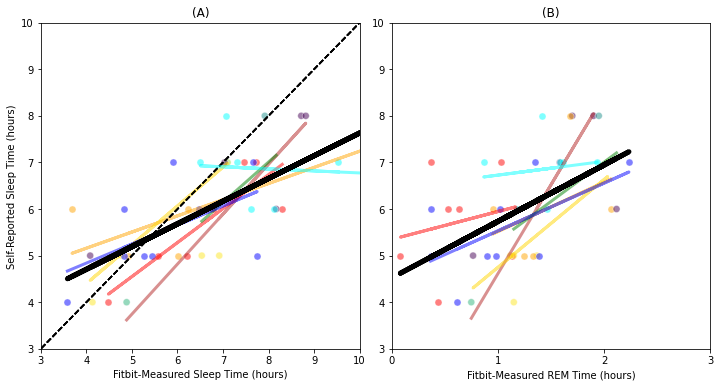

In [17]:
fig, axes = plt.subplots(1,2,figsize=(12,6))
colors = ['firebrick','red','orange','gold','green','blue','cyan','violet','black']
i = 0
for pid in sleepTime['beiwe'].unique():
    sleepByID = sleepTime[sleepTime['beiwe'] == pid]
    print(f'{pid}: {len(sleepByID)}')
    if len(sleepByID) > 1:
        ax = axes[0]
        sns.scatterplot(x='TotalHoursAsleep',y='hours',alpha=0.5,s=50,data=sleepByID,color=colors[i],ax=ax,label=pid)
        # y=x
        ax.plot([0,11],[0,11],linestyle='dashed',alpha=0.8,color='black')
        # x-axis
        ax.set_xlim([3,10])
        ax.set_xticks(np.arange(3,11))
        ax.set_xlabel('Fitbit-Measured Sleep Time (hours)')
        # y-axis
        ax.set_ylim([3,10])
        ax.set_yticks(np.arange(3,11))
        ax.set_ylabel('Self-Reported Sleep Time (hours)')
        
        X = sleepByID['TotalHoursAsleep'].values
        Y = sleepByID['hours'].values
        t = np.arange(len(X))
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        ## Line of Best Fit
        ax.plot(X[:,1],predictions,color=colors[i],alpha=0.5,linewidth=3)
        
        ax = axes[1]
        sns.scatterplot(x='TotalHoursREM',y='hours',alpha=0.5,s=50,data=sleepByID,color=colors[i],ax=ax,label=pid)
        # x-axis
        ax.set_xlim([0,3])
        ax.set_xticks(np.arange(0,4))
        ax.set_xlabel('Fitbit-Measured REM Time (hours)')
        # y-axis
        ax.set_ylim([3,10])
        ax.set_yticks(np.arange(3,11))
        ax.set_ylabel('')
        
        X = sleepByID['TotalHoursREM'].values
        Y = sleepByID['hours'].values
        t = np.arange(len(X))
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        ## Line of Best Fit
        ax.plot(X[:,1],predictions,color=colors[i],alpha=0.5,linewidth=3,label=pid)

        i += 1
    
data = sleepTime
md = smf.mixedlm("hours ~ TotalHoursAsleep", data, groups=data["beiwe"])
mdf = md.fit()
#print(mdf.summary())
axes[0].plot(sleepTime['TotalHoursAsleep'],mdf.predict(sleepTime['TotalHoursAsleep']),color='black',linewidth=5)
#axes[0].text(8,3.5,f'p-val (intercept): {round(mdf.pvalues[0],3)}',va='top')
axes[0].set_title('(A)')

md = smf.mixedlm("hours ~ TotalHoursREM", data, groups=data["beiwe"])
mdf = md.fit()
#print(mdf.summary())
axes[1].plot(sleepTime['TotalHoursREM'],mdf.predict(sleepTime['TotalHoursREM']),color='black',linewidth=5,label='Mixed Effect Regression')
#axes[1].text(2,3.5,f'p-val (intercept): {round(mdf.pvalues[0],3)}',va='top')
axes[1].set_title('(B)')

axes[0].get_legend().remove()
axes[1].get_legend().remove()

plt.subplots_adjust(hspace=0.2,wspace=0.1)
plt.savefig('/Users/hagenfritz/Projects/utx000/reports/figures/framework_paper/ut3000-fitbit-beiwe-tst-tst-LMEscatter.pdf',bbox_inches='tight')
plt.show()
plt.close()

2qki3fim: 4
4vbys6c4: 8
yiylwp46: 5
oo7mbow3: 4
ej8gbvzs: 4
fwx7pdjp: 9
7ao7sz2v: 4
36dsqll3: 11


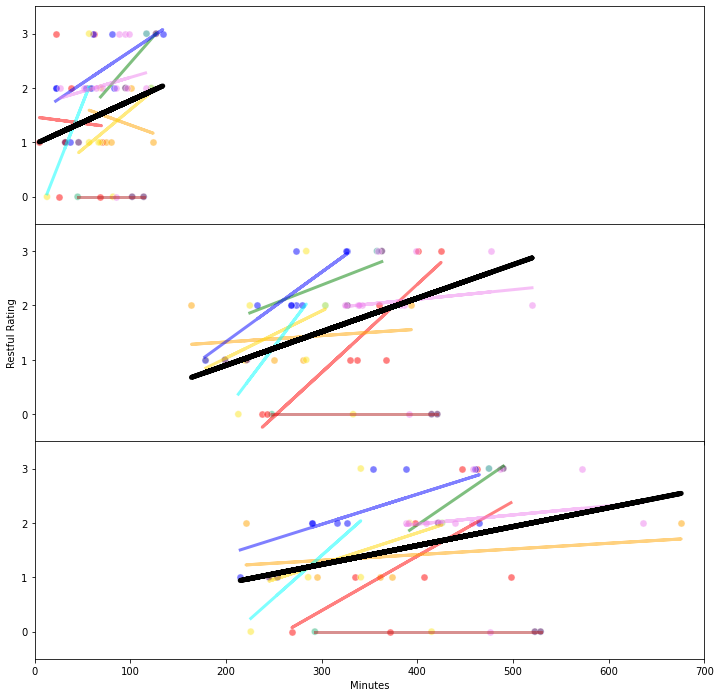

In [18]:
fig, axes = plt.subplots(3,1,figsize=(12,12),sharex='col')
i = 0
for pid in sleepRestful['beiwe'].unique():
    sleepRestfulByID = sleepRestful[sleepRestful['beiwe'] == pid]
    print(f'{pid}: {len(sleepRestfulByID)}')
    if len(sleepRestfulByID) > 1:
        ax = axes[0]
        sns.scatterplot(x='TotalMinutesREM',y='restful',alpha=0.5,s=50,data=sleepRestfulByID,color=colors[i],ax=ax,label=pid)
        
        X = sleepRestfulByID['TotalMinutesREM'].values
        Y = sleepRestfulByID['restful'].values
        t = np.arange(len(X))
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        ## Line of Best Fit
        ax.plot(X[:,1],predictions,color=colors[i],alpha=0.5,linewidth=3)
        
        ax = axes[1]
        sns.scatterplot(x='TotalMinutesNREM',y='restful',alpha=0.5,s=50,data=sleepRestfulByID,color=colors[i],ax=ax,label=pid)
        
        X = sleepRestfulByID['TotalMinutesNREM'].values
        Y = sleepRestfulByID['restful'].values
        t = np.arange(len(X))
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        ## Line of Best Fit
        ax.plot(X[:,1],predictions,color=colors[i],alpha=0.5,linewidth=3,label=pid)
        
        ax = axes[2]
        sns.scatterplot(x='TotalMinutesAsleep',y='restful',alpha=0.5,s=50,data=sleepRestfulByID,color=colors[i],ax=ax,label=pid)
        
        X = sleepRestfulByID['TotalMinutesAsleep'].values
        Y = sleepRestfulByID['restful'].values
        t = np.arange(len(X))
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        ## Line of Best Fit
        ax.plot(X[:,1],predictions,color=colors[i],alpha=0.5,linewidth=3,label=pid)

        i += 1
      
for loc, metric in zip([0,1,2],['TotalMinutesREM','TotalMinutesNREM','TotalMinutesAsleep']):
    data = sleepRestful
    md = smf.mixedlm(f"restful ~ {metric}", data, groups=data["beiwe"])
    mdf = md.fit()
    #print(mdf.summary())
    axes[loc].plot(sleepRestful[metric],mdf.predict(sleepRestful[metric]),color='black',linewidth=5)
    #axes[0].text(8,3.5,f'p-val (intercept): {round(mdf.pvalues[0],3)}',va='top')
    
    axes[loc].get_legend().remove()
    axes[loc].set_yticks([0,1,2,3])
    axes[loc].set_ylim([-0.5,3.5])
    axes[loc].set_xticks(np.arange(0,800,100))
    axes[loc].set_xlim([0,700])
    
    if loc == 1:
        axes[loc].set_ylabel('Restful Rating')
    else:
        axes[loc].set_ylabel('')
        
        
axes[2].set_xlabel('Minutes')
plt.subplots_adjust(hspace=0)
plt.savefig('/Users/hagenfritz/Projects/utx000/reports/figures/framework_paper/ut3000-fitbit-beiwe-REMandNREM-restful-LMEscatter.pdf',bbox_inches='tight')

plt.show()
plt.close()

2qki3fim: 4
4vbys6c4: 8
yiylwp46: 5
oo7mbow3: 4
ej8gbvzs: 4
fwx7pdjp: 9
7ao7sz2v: 4
36dsqll3: 11


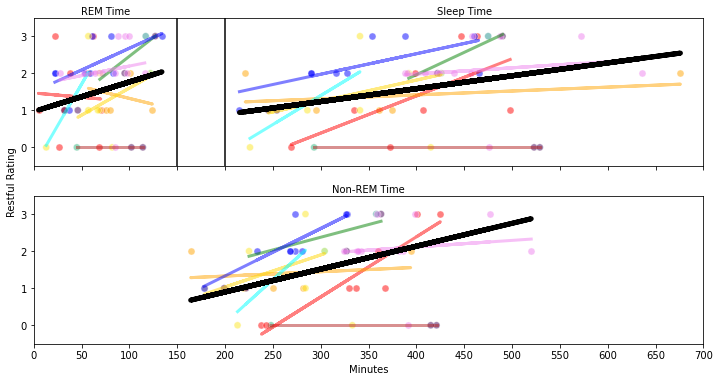

In [32]:
fig, axes = plt.subplots(2,1,figsize=(12,6),sharex='col')
i = 0
for pid in sleepRestful['beiwe'].unique():
    sleepRestfulByID = sleepRestful[sleepRestful['beiwe'] == pid]
    print(f'{pid}: {len(sleepRestfulByID)}')
    if len(sleepRestfulByID) > 1:
        ax = axes[0]
        sns.scatterplot(x='TotalMinutesREM',y='restful',alpha=0.5,s=50,data=sleepRestfulByID,color=colors[i],ax=ax,label=pid)
        
        X = sleepRestfulByID['TotalMinutesREM'].values
        Y = sleepRestfulByID['restful'].values
        t = np.arange(len(X))
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        ## Line of Best Fit
        ax.plot(X[:,1],predictions,color=colors[i],alpha=0.5,linewidth=3)
        
        ax = axes[1]
        sns.scatterplot(x='TotalMinutesNREM',y='restful',alpha=0.5,s=50,data=sleepRestfulByID,color=colors[i],ax=ax,label=pid)
        
        X = sleepRestfulByID['TotalMinutesNREM'].values
        Y = sleepRestfulByID['restful'].values
        t = np.arange(len(X))
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        ## Line of Best Fit
        ax.plot(X[:,1],predictions,color=colors[i],alpha=0.5,linewidth=3,label=pid)
        
        ax = axes[0]
        sns.scatterplot(x='TotalMinutesAsleep',y='restful',alpha=0.5,s=50,data=sleepRestfulByID,color=colors[i],ax=ax,label=pid)
        
        X = sleepRestfulByID['TotalMinutesAsleep'].values
        Y = sleepRestfulByID['restful'].values
        t = np.arange(len(X))
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        predictions = model.predict(X) # make the predictions by the model

        ## Line of Best Fit
        ax.plot(X[:,1],predictions,color=colors[i],alpha=0.5,linewidth=3,label=pid)

        i += 1
      
for loc, metric in zip([0,1,0],['TotalMinutesREM','TotalMinutesNREM','TotalMinutesAsleep']):
    data = sleepRestful
    md = smf.mixedlm(f"restful ~ {metric}", data, groups=data["beiwe"])
    mdf = md.fit()
    #print(mdf.summary())
    axes[loc].plot(sleepRestful[metric],mdf.predict(sleepRestful[metric]),color='black',linewidth=5)
    #axes[0].text(8,3.5,f'p-val (intercept): {round(mdf.pvalues[0],3)}',va='top')
    
    try:
        axes[loc].get_legend().remove()
    except:
        pass
    axes[loc].set_yticks([0,1,2,3])
    axes[loc].set_ylim([-0.5,3.5])
    axes[loc].set_xticks(np.arange(0,750,50))
    axes[loc].set_xlim([0,700])
    axes[loc].set_ylabel('')
        
axes[1].set_xlabel('Minutes')

axes[0].axvline(150,color='black')
axes[0].axvline(200,color='black')
axes[0].text(75,3.8,'REM Time',ha='center',va='top')
axes[0].text(450,3.8,'Sleep Time',ha='center',va='top')
axes[1].text(350,3.8,'Non-REM Time',ha='center',va='top')
fig.text(0.1, 0.5, 'Restful Rating', ha='center', va='center', rotation='vertical')
plt.subplots_adjust(hspace=0.2)
plt.savefig('/Users/hagenfritz/Projects/utx000/reports/figures/framework_paper/ut3000-fitbit-beiwe-REMandNREM-restful-LMEscatter.pdf',bbox_inches='tight')

plt.show()
plt.close()